<a href="https://colab.research.google.com/github/govardhanspace/Projects/blob/main/Gensim_TopicModelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP notes/05-Topic-Modeling/quora_questions.csv")

In [5]:
df.head()

,Question
0,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...
2,How can I increase the speed of my internet co...
3,Why am I mentally very lonely? How can I solve...
4,"Which one dissolve in water quikly sugar, salt..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404289 entries, 0 to 404288
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Question  404289 non-null  object
dtypes: object(1)
memory usage: 3.1+ MB


In [30]:
df_small = df.loc[0:10000]
df_small.head()

,Question
0,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...
2,How can I increase the speed of my internet co...
3,Why am I mentally very lonely? How can I solve...
4,"Which one dissolve in water quikly sugar, salt..."


In [31]:
df_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  10001 non-null  object
dtypes: object(1)
memory usage: 78.3+ KB


In [32]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
        yield(sent)

# Convert to list
data = df_small.Question.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['what', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market', 'in', 'india']]


In [33]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [34]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    activated = spacy.prefer_gpu()
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [35]:
len(data_ready)

10001

In [36]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

print(lda_model.print_topics())

[(0, '0.044*"mean" + 0.034*"study" + 0.032*"time" + 0.022*"feel" + 0.019*"someone" + 0.017*"family" + 0.017*"find" + 0.017*"future" + 0.016*"man" + 0.015*"pay"'), (1, '0.046*"become" + 0.046*"people" + 0.044*"year" + 0.030*"give" + 0.022*"exist" + 0.019*"develop" + 0.016*"next" + 0.014*"processor" + 0.013*"type" + 0.012*"part"'), (2, '0.043*"learn" + 0.036*"friend" + 0.036*"start" + 0.031*"bad" + 0.027*"book" + 0.027*"guy" + 0.024*"exam" + 0.022*"car" + 0.019*"business" + 0.015*"female"'), (3, '0.078*"travel" + 0.047*"way" + 0.028*"day" + 0.028*"stop" + 0.027*"much" + 0.021*"change" + 0.021*"website" + 0.019*"possible" + 0.018*"place" + 0.016*"consider"'), (4, '0.060*"difference" + 0.027*"point" + 0.027*"new" + 0.022*"job" + 0.021*"love" + 0.021*"quora" + 0.019*"back" + 0.018*"question" + 0.018*"really" + 0.017*"view"'), (5, '0.039*"work" + 0.035*"example" + 0.034*"company" + 0.028*"happen" + 0.024*"show" + 0.019*"put" + 0.018*"apply" + 0.018*"experience" + 0.016*"food" + 0.015*"child"

In [39]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df._append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2,0.3862,"learn, friend, start, bad, book, guy, exam, ca...","[step, step, guide, invest, share, market]"
1,1,6,0.6258,"first, well, ever, long, movie, thing, live, w...","[story, kohinoor, diamond]"
2,2,7,0.6329,"safe, woman, life, note, country, machine, mon...","[increase, speed, internet, connection, vpn]"
3,3,0,0.3833,"mean, study, time, feel, someone, family, find...","[mentally, lonely, solve]"
4,4,3,0.4030,"travel, way, day, stop, much, change, website,...","[dissolve, water, quikly, sugar, salt, oxide]"
5,5,7,0.5973,"safe, woman, life, note, country, machine, mon...","[cap, rise]"
6,6,2,0.5979,"learn, friend, start, bad, book, guy, exam, ca...","[buy, tiago]"
7,7,1,0.1250,"become, people, year, give, exist, develop, ne...",[geologist]
8,8,5,0.5625,"work, example, company, happen, show, put, app...",[instead]
9,9,2,0.5979,"learn, friend, start, bad, book, guy, exam, ca...","[hack, charter]"


Sometimes you want to get samples of sentences that most represent a given topic. This code gets the most exemplar sentence for each topic.



In [40]:
# Sometimes you want to get samples of sentences that most represent a given topic.
# This code gets the most exemplar sentence for each topic.

# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.8795,"mean, study, time, feel, someone, family, find, future, man, pay","[send, message, android, phone, android, phone, bluetooth]"
1,1,0.8903,"become, people, year, give, exist, develop, next, processor, type, part","[topic, recognize, topic, biography, rule, topic, specific, bio]"
2,2,0.8750,"learn, friend, start, bad, book, guy, exam, car, business, female","[export, web, calendar, web, calendar, outlook]"
3,3,0.8750,"travel, way, day, stop, much, change, website, possible, place, consider","[various, range, stylish, ceramic, floor, tile]"
4,4,0.8905,"difference, point, new, job, love, quora, back, question, really, view","[liquid, cotton, egyptian, cotton, bamboo, bed, sheet]"
5,5,0.9028,"work, example, company, happen, show, put, apply, experience, food, child","[party, put, ballot, approval, put, sander, ballot, approval]"
6,6,0.9080,"first, well, ever, long, movie, thing, live, world, email, eat","[domain, name, trademark, trademark, domain, name, seize, domain, name]"
7,7,0.8710,"safe, woman, life, note, country, machine, money, month, alone, address","[inkjet, printer, color, ink, print, black, white, document]"


Though you’ve already seen what are the topic keywords in each topic, a word cloud with the size of the words proportional to the weight is a pleasant sight. The coloring of the topics I’ve taken here is followed in the subsequent plots as well.

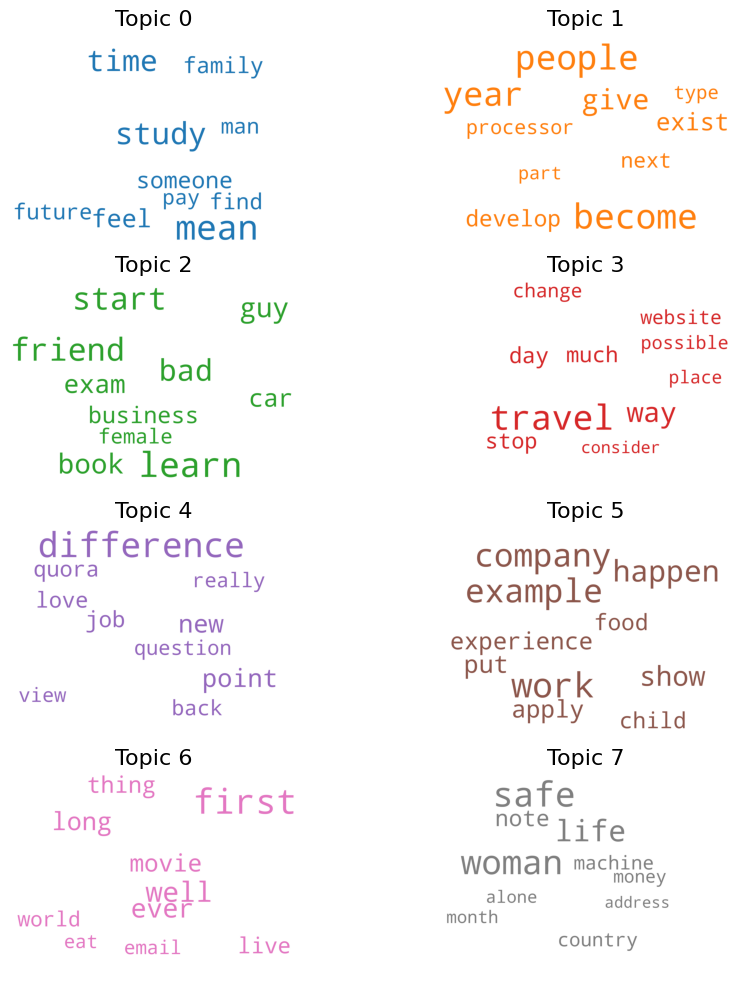

In [49]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.

Let’s plot the word counts and the weights of each keyword in the same chart.

We want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important. The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process.

<ipython-input-63-7e82ab0c430c>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


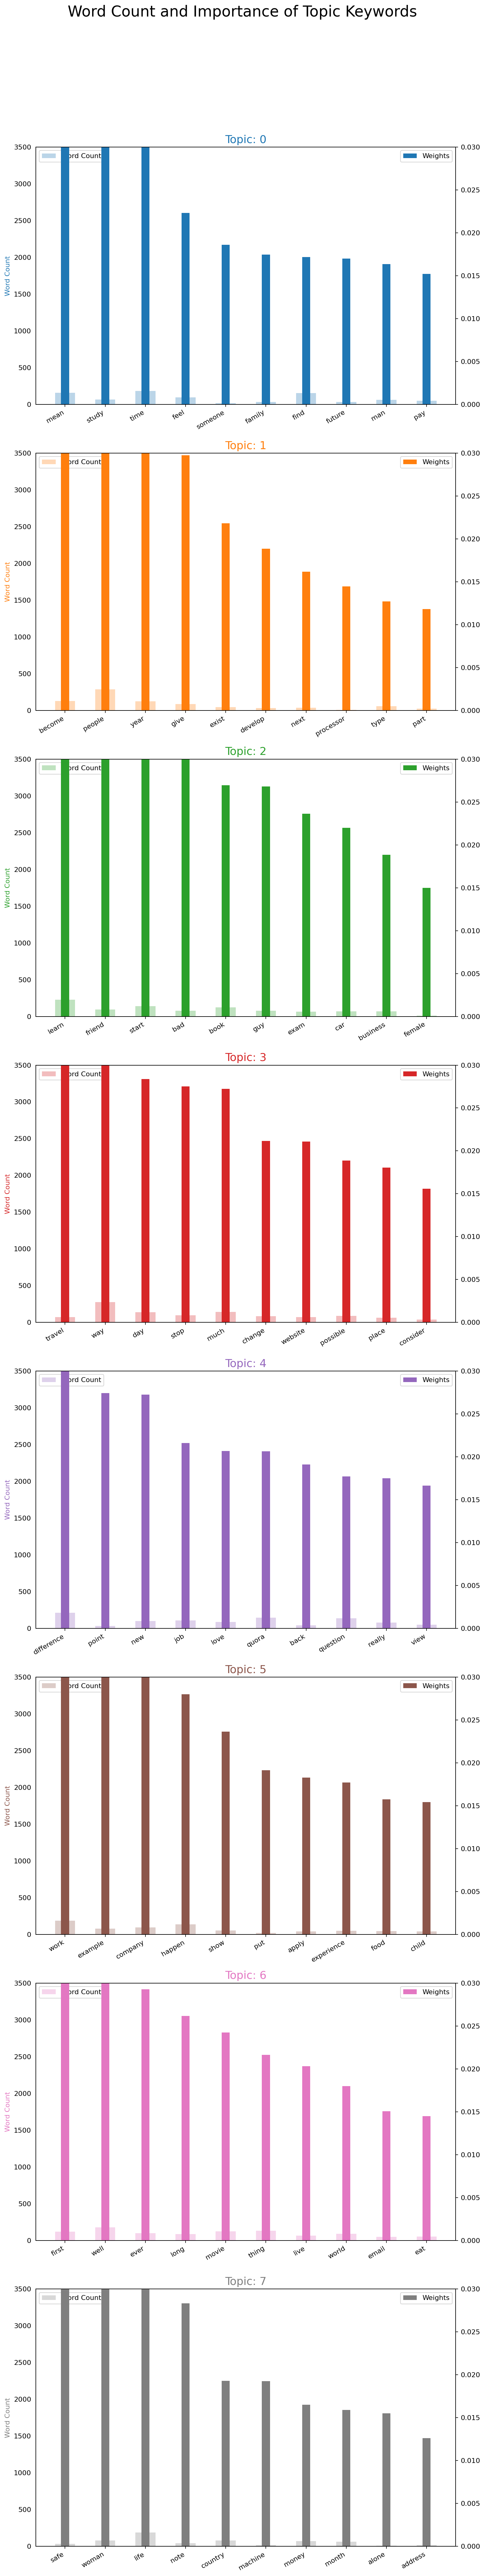

In [63]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(8, 1, figsize=(10,50), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

In [75]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.282636 -0.154579       1        1  13.599505
3     -0.230637 -0.129193       2        1  13.106457
6      0.028096  0.297054       3        1  12.857324
2     -0.000456 -0.016886       4        1  12.656269
0     -0.026077  0.079442       5        1  12.643473
1      0.009477  0.010791       6        1  12.334810
5      0.028039 -0.003200       7        1  12.178887
7     -0.091078 -0.083428       8        1  10.623274, topic_info=            Term        Freq       Total Category  logprob  loglift
114       travel  394.000000  394.000000  Default  30.0000  30.0000
1144        safe  301.000000  301.000000  Default  29.0000  29.0000
411        woman  291.000000  291.000000  Default  28.0000  28.0000
287   difference  314.000000  314.000000  Default  27.0000  27.0000
42         first  266.000000  266.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
1098       teach   23.631340   24.572478   Topic8  -5.1596   2.2031
1062     protein   25.573158   26.632989   Topic8  -5.0806   2.2015
655         star   34.493109   36.397470   Topic8  -4.7814   2.1884
4184       alone   63.776610   82.250858   Topic8  -4.1668   1.9877
633       dollar   45.008954   54.095643   Topic8  -4.5153   2.0582

[285 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
255       4  0.988151    account
2509      8  0.984986    address
2425      1  0.968248    advance
360       1  0.973886  advantage
460       2  0.986786        age
...     ...       ...        ...
309       7  0.994903       work
354       3  0.994863      world
1331      3  0.982644  world_war
916       3  0.982299      write
125       6  0.995822       year

[264 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 7, 3, 1, 2, 6, 8])